In [ ]:
import pandas as pd
import os
from datetime import datetime, timedelta
import glob
import pandas as pd
import random
import numpy as np
import seaborn as sns
import ast
import json
import os
import re
import itertools
import folium
import h3

import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.patches as patches
from itertools import combinations
from collections import defaultdict
from collections import Counter
from typing import Dict, Set, List, Optional, Tuple

In [ ]:
from utils.h3hierarchy import create_h3_hierarchical_tree
from utils.metrics import compute_discernability_and_cavg_sparse

### Data preparation

In [ ]:
df_gps = pd.read_csv("C:\\Users\\dmc\\Desktop\\extracted_trips_data.csv")

df_people = pd.read_csv("C:\\Users\\dmc\\Desktop\\individuals_dataset.csv")
df_people = df_people[df_people['GPS_RECORD'] == True]

In [5]:
df_merged = pd.merge(
    df_gps,
    df_people[['ID', 'WEIGHT_INDIV']],
    left_on='person_id',
    right_on='ID',
    how='inner'
).drop(columns='ID')

In [6]:
h3_resolution = 10

df_merged['start_h3'] = df_merged.apply(lambda row: h3.latlng_to_cell(row['start_lat'], row['start_lon'], h3_resolution), axis=1)
df_merged['end_h3'] = df_merged.apply(lambda row: h3.latlng_to_cell(row['end_lat'], row['end_lon'], h3_resolution), axis=1)

In [8]:
media_peso = df_merged['WEIGHT_INDIV'].mean()
print(f"📏 Media del peso individuale: {media_peso:.3f}")

📏 Media del peso individuale: 2674.163


In [9]:
od_matrix_first = df_merged.groupby(['start_h3', 'end_h3']).agg({
    'WEIGHT_INDIV': ['sum', 'count']
}).reset_index()

od_matrix_first.columns = ['start_h3', 'end_h3', 'total_weight', 'count']

In [ ]:
parent_hexes = ["861fb4667ffffff", "861fb4677ffffff", "861fb466fffffff", "861fb4647ffffff", "861fb475fffffff"]

target_resolution = 10
start_valid_h3 = set()
end_valid_h3 = set()

for parent in parent_hexes:
    children = h3.cell_to_children(parent, target_resolution)
    for child in children:
        start_valid_h3.add(child)
        end_valid_h3.add(child)

mask = (
    (od_matrix_first["start_h3"].isin(start_valid_h3))
    & (od_matrix_first["end_h3"].isin(end_valid_h3))
)

od_matrix_first = od_matrix_first[mask].copy()
print(f"Numero di righe filtrate: {len(od_matrix_first):,}")

Numero di righe filtrate: 23,264


In [ ]:
od_matrix = od_matrix_first.copy()
od_matrix

### ODkAnon algorithm

##### Suppression phase

In [ ]:
def fast_pre_generalization_filter(
    od_matrix: pd.DataFrame,
    k_threshold: int = 10,
    max_generalization_levels: int = 3,
    suppression_budget_percent: float = 0.1
) -> pd.DataFrame:
    """
    Filter OD couples which are not k-anonymous even after generalizing to the maximum level
    """
    print("⚙️ Inizio filtro veloce pre-generalizzazione...")

    original_size = len(od_matrix)
    max_suppressions = int(original_size * suppression_budget_percent)
    print(f"📊 Budget suppression: {max_suppressions} righe su {original_size} ({suppression_budget_percent*100:.1f}%)")

    mapping_cache = {}

    def generalize(h, level_down):
        res = h3.get_resolution(h)
        target_res = res - level_down
        if target_res < 0:
            target_res = 0
        key = (h, target_res)
        if key not in mapping_cache:
            mapping_cache[key] = h3.cell_to_parent(h, target_res) if res > target_res else h
        return mapping_cache[key]

    od_working = od_matrix.copy()
    for lvl in range(max_generalization_levels + 1):
        od_working[f'start_gen_{lvl}'] = od_working['start_h3'].apply(lambda x: generalize(x, lvl))
        od_working[f'end_gen_{lvl}'] = od_working['end_h3'].apply(lambda x: generalize(x, lvl))

    results = []
    for lvl in range(max_generalization_levels + 1):
        grouped = od_working.groupby([f'start_gen_{lvl}', f'end_gen_{lvl}'])['count'].sum().reset_index()
        grouped.columns = ['start_gen', 'end_gen', 'agg_count']
        grouped['level'] = lvl
        results.append(grouped)

    all_levels = pd.concat(results)
    
    od_with_id = od_working.reset_index().rename(columns={'index': 'row_id'})

    valid_pairs = set()
    for lvl in range(max_generalization_levels + 1):
        merged = od_with_id.merge(
            all_levels[all_levels['level'] == lvl],
            left_on=[f'start_gen_{lvl}', f'end_gen_{lvl}'],
            right_on=['start_gen', 'end_gen'],
            how='left'
        )
        valid = merged[merged['agg_count'] >= k_threshold]
        valid_pairs.update(valid['row_id'].tolist())

    all_row_ids = set(od_with_id['row_id'].tolist())
    problematic_rows = all_row_ids - valid_pairs
    
    print(f"🔍 Righe k-anonime con generalizzazione: {len(valid_pairs)}")
    print(f"⚠️ Righe problematiche: {len(problematic_rows)}")

    if len(problematic_rows) <= max_suppressions:
        print(f"✅ Budget sufficiente: soppressione di tutte le {len(problematic_rows)} righe problematiche")
        rows_to_keep = valid_pairs
        suppressed_count = len(problematic_rows)
    else:
        print(f"🎯 Budget insufficiente: sopprimi prima le righe con count più basso")
        
        problematic_df = od_with_id[od_with_id['row_id'].isin(problematic_rows)].copy()
        
        to_suppress = problematic_df.nsmallest(max_suppressions, 'count')['row_id'].tolist()
        
        rows_to_suppress = set(to_suppress)
        rows_to_keep = valid_pairs | (problematic_rows - rows_to_suppress)
        suppressed_count = len(to_suppress)
        
        print(f"📋 Soppresse {suppressed_count} righe")

    filtered = od_with_id[od_with_id['row_id'].isin(rows_to_keep)].copy()
    filtered = filtered[['start_h3', 'end_h3', 'total_weight', 'count']]

    kept_count = len(filtered)
    
    print(f"📈 Risultati finali:")
    print(f"   • Righe mantenute: {kept_count} / {original_size} ({kept_count/original_size*100:.1f}%)")
    print(f"   • Righe soppresse: {suppressed_count} ({suppressed_count/original_size*100:.1f}%)")
    print(f"   • Budget utilizzato: {suppressed_count} / {max_suppressions}")

    return filtered, suppressed_count

od_matrix, suppressed_count = fast_pre_generalization_filter(od_matrix, k_threshold=10, max_generalization_levels=3, suppression_budget_percent=0.1)

⚙️ Inizio filtro veloce pre-generalizzazione...
📊 Budget suppression: 2326 righe su 23264 (10.0%)
🔍 Righe k-anonime con generalizzazione: 21725
⚠️ Righe problematiche: 1539
✅ Budget sufficiente: soppressione di tutte le 1539 righe problematiche
📈 Risultati finali:
   • Righe mantenute: 21725 / 23264 (93.4%)
   • Righe soppresse: 1539 (6.6%)
   • Budget utilizzato: 1539 / 2326


In [ ]:
filtered_df = df_merged.merge(
    od_matrix[['start_h3', 'end_h3']],
    on=['start_h3', 'end_h3'],
    how='inner'
)
filtered_df

##### Hierarchical tree creation phase

In [ ]:
tree_start = create_h3_hierarchical_tree(od_matrix, target_resolution=10, hex_column='start_h3')

🔍 Analizzando risoluzione ottimale per radice...
  - Risoluzione 0: 1 nodi
  - Risoluzione 1: 1 nodi
  - Risoluzione 2: 1 nodi
  - Risoluzione 3: 1 nodi
  - Risoluzione 4: 1 nodi
  - Risoluzione 5: 2 nodi
  - Risoluzione 6: 5 nodi
  - Risoluzione 7: 35 nodi
  - Risoluzione 8: 243 nodi
  - Risoluzione 9: 1492 nodi
  - Risoluzione 10: 6377 nodi
✅ Risoluzione ottimale trovata: 4
🏗️ Costruendo albero da risoluzione 4 a 10

📈 STATISTICHE ALBERO OTTIMIZZATO (START_H3)
• Nodi totali: 8,155
• Range risoluzione: 4 → 10
• Risoluzione radice: 4
• Risoluzione foglie: 10
• Nodi per risoluzione:
  - Risoluzione 4: 1 nodi
  - Risoluzione 5: 2 nodi
  - Risoluzione 6: 5 nodi
  - Risoluzione 7: 35 nodi
  - Risoluzione 8: 243 nodi
  - Risoluzione 9: 1,492 nodi
  - Risoluzione 10: 6,377 nodi

💡 OTTIMIZZAZIONI:
• Risoluzioni risparmiate: 4
• Efficienza albero: 7/11 livelli utilizzati

🌳 STRUTTURA ALBERO OTTIMIZZATA
📏 Range risoluzione: 4 → 10
└─ 841fb47ffffffff (res:4, total_weight:68975542, count:26650, c

In [ ]:
tree_end = create_h3_hierarchical_tree(od_matrix, target_resolution=10, hex_column='end_h3')

🔍 Analizzando risoluzione ottimale per radice...
  - Risoluzione 0: 1 nodi
  - Risoluzione 1: 1 nodi
  - Risoluzione 2: 1 nodi
  - Risoluzione 3: 1 nodi
  - Risoluzione 4: 1 nodi
  - Risoluzione 5: 2 nodi
  - Risoluzione 6: 5 nodi
  - Risoluzione 7: 35 nodi
  - Risoluzione 8: 242 nodi
  - Risoluzione 9: 1474 nodi
  - Risoluzione 10: 6382 nodi
✅ Risoluzione ottimale trovata: 4
🏗️ Costruendo albero da risoluzione 4 a 10

📈 STATISTICHE ALBERO OTTIMIZZATO (END_H3)
• Nodi totali: 8,141
• Range risoluzione: 4 → 10
• Risoluzione radice: 4
• Risoluzione foglie: 10
• Nodi per risoluzione:
  - Risoluzione 4: 1 nodi
  - Risoluzione 5: 2 nodi
  - Risoluzione 6: 5 nodi
  - Risoluzione 7: 35 nodi
  - Risoluzione 8: 242 nodi
  - Risoluzione 9: 1,474 nodi
  - Risoluzione 10: 6,382 nodi

💡 OTTIMIZZAZIONI:
• Risoluzioni risparmiate: 4
• Efficienza albero: 7/11 livelli utilizzati

🌳 STRUTTURA ALBERO OTTIMIZZATA
📏 Range risoluzione: 4 → 10
└─ 841fb47ffffffff (res:4, total_weight:68975538, count:26650, chi

##### Generalization phase

In [ ]:
from collections import defaultdict, Counter
from typing import Dict, Set, List, Optional, Tuple
import scipy.sparse as sp
from numba import jit, njit
import time
import pandas as pd
import numpy as np
import h3

class OptimizedH3GeneralizedODMatrix:
    """
    Optimized version for very large OD matrices with k-anonymity based on counts
    Main matrix: count (for k-anonymity)
    Secondary matrix: weights (kept for analysis)
    """
    
    def __init__(self, od_matrix: pd.DataFrame, tree_start, tree_end, k_threshold: int = 10):
        self.original_od_matrix = od_matrix
        self.tree_start = tree_start
        self.tree_end = tree_end
        self.k_threshold = k_threshold
        
        self.current_matrix_sparse = None
        self.current_weights_sparse = None
        
        self.start_to_idx = {}  
        self.end_to_idx = {}    
        self.idx_to_start = {}  
        self.idx_to_end = {}    
        
        self.sibling_groups_cache = {}
        self.parent_cache = {}
        
        self.generalization_history = []
        
    def initialize_optimized_matrix(self):
        """Initialize using sparse matrices and smart pre-processing"""
        print("🔧 Optimized initialization...")
        
        non_zero_od = self.original_od_matrix[self.original_od_matrix['count'] > 0].copy()
        print(f"📊 Filtered data: {len(non_zero_od):,} non-zero cells out of {len(self.original_od_matrix):,}")
        
        used_starts = set(non_zero_od['start_h3'].unique())
        used_ends = set(non_zero_od['end_h3'].unique())
        
        target_starts = self._get_target_resolution_hexagons(used_starts, self.tree_start)
        target_ends = self._get_target_resolution_hexagons(used_ends, self.tree_end)
        
        print(f"🎯 Target hexagons: {len(target_starts)} origins, {len(target_ends)} destinations")
        
        self.start_to_idx = {h3_id: idx for idx, h3_id in enumerate(sorted(target_starts))}
        self.end_to_idx = {h3_id: idx for idx, h3_id in enumerate(sorted(target_ends))}
        self.idx_to_start = {idx: h3_id for h3_id, idx in self.start_to_idx.items()}
        self.idx_to_end = {idx: h3_id for h3_id, idx in self.end_to_idx.items()}
        
        self.current_matrix_sparse, self.current_weights_sparse = self._build_sparse_matrices(
            non_zero_od, target_starts, target_ends
        )
        
        self._precompute_sibling_groups()
        
        print(f"✅ Sparse matrices initialized: {self.current_matrix_sparse.shape} "
              f"({self.current_matrix_sparse.nnz:,} non-zero elements)")
        
        return self
    
    def _get_target_resolution_hexagons(self, hexagons: Set[str], tree) -> Set[str]:
        """Get target resolution hexagons only for those used"""
        target_hexagons = set()
        target_res = tree.target_resolution
        
        for hex_id in hexagons:
            current_res = h3.get_resolution(hex_id)
            
            if current_res == target_res:
                target_hexagons.add(hex_id)
            elif current_res < target_res:
                if hex_id in tree.nodes:
                    children = self._get_children_at_resolution_fast(hex_id, target_res)
                    target_hexagons.update(children)
            else:
                parent = h3.cell_to_parent(hex_id, target_res)
                target_hexagons.add(parent)
        
        return target_hexagons
    
    def _get_children_at_resolution_fast(self, hex_id: str, target_res: int) -> Set[str]:
        """Fast version to get children"""
        current_res = h3.get_resolution(hex_id)
        if current_res == target_res:
            return {hex_id}
        
        cache_key = (hex_id, target_res)
        if cache_key in self.sibling_groups_cache:
            return self.sibling_groups_cache[cache_key]
        
        children = set()
        queue = [hex_id]
        
        while queue:
            current = queue.pop(0)
            current_r = h3.get_resolution(current)
            
            if current_r == target_res:
                children.add(current)
            elif current_r < target_res:
                direct_children = h3.cell_to_children(current, current_r + 1)
                queue.extend(direct_children)
        
        self.sibling_groups_cache[cache_key] = children
        return children
    
    def _build_sparse_matrices(self, od_data: pd.DataFrame, target_starts: Set[str], target_ends: Set[str]) -> Tuple[sp.csr_matrix, sp.csr_matrix]:
        """Builds separate sparse matrices for counts (main) and weights (secondary)"""
        rows_counts, cols_counts, data_counts = [], [], []
        rows_weights, cols_weights, data_weights = [], [], []
        
        print("🔨 Building sparse matrices...")
        
        grouped = od_data.groupby(['start_h3', 'end_h3']).agg({
            'count': 'sum',
            'total_weight': 'sum'
        }).reset_index()
        
        for _, row in grouped.iterrows():
            start_h3 = row['start_h3']
            end_h3 = row['end_h3']
            count = row['count']
            weight = row['total_weight']
            
            mapped_start = self._map_to_target_fast(start_h3, target_starts, self.tree_start)
            mapped_end = self._map_to_target_fast(end_h3, target_ends, self.tree_end)
            
            if mapped_start and mapped_end:
                start_idx = self.start_to_idx[mapped_start]
                end_idx = self.end_to_idx[mapped_end]
                
                rows_counts.append(end_idx)
                cols_counts.append(start_idx)
                data_counts.append(count)
                
                rows_weights.append(end_idx)
                cols_weights.append(start_idx)
                data_weights.append(weight)
        
        shape = (len(target_ends), len(target_starts))
        
        matrix_counts_coo = sp.coo_matrix((data_counts, (rows_counts, cols_counts)), shape=shape)
        matrix_counts_csr = matrix_counts_coo.tocsr()
        matrix_counts_csr.sum_duplicates()
        
        matrix_weights_coo = sp.coo_matrix((data_weights, (rows_weights, cols_weights)), shape=shape)
        matrix_weights_csr = matrix_weights_coo.tocsr()
        matrix_weights_csr.sum_duplicates()
        
        return matrix_counts_csr, matrix_weights_csr
    
    def _map_to_target_fast(self, h3_id: str, target_nodes: Set[str], tree) -> Optional[str]:
        """Fast version of mapping with cache"""
        if h3_id in target_nodes:
            return h3_id
        
        if h3_id in self.parent_cache:
            cached_parent = self.parent_cache[h3_id]
            if cached_parent in target_nodes:
                return cached_parent
        
        current_res = h3.get_resolution(h3_id)
        target_res = tree.target_resolution
        
        if current_res > target_res:
            parent = h3.cell_to_parent(h3_id, target_res)
            self.parent_cache[h3_id] = parent
            return parent if parent in target_nodes else None
        elif current_res < target_res:
            for target in target_nodes:
                if self._is_descendant_fast(target, h3_id):
                    return target
        
        return None
    
    def _is_descendant_fast(self, child_h3: str, parent_h3: str) -> bool:
        """Optimized descendant check"""
        child_res = h3.get_resolution(child_h3)
        parent_res = h3.get_resolution(parent_h3)
        
        if parent_res >= child_res:
            return False
        
        cache_key = (child_h3, parent_h3)
        if cache_key in self.parent_cache:
            return self.parent_cache[cache_key]
        
        current = child_h3
        while h3.get_resolution(current) > parent_res:
            current = h3.cell_to_parent(current, h3.get_resolution(current) - 1)
        
        result = current == parent_h3
        self.parent_cache[cache_key] = result
        return result
    
    def _precompute_sibling_groups(self):
        """Pre-compute all possible sibling groups"""
        print("🧠 Pre-computing sibling groups...")
        
        self.start_sibling_groups = self._compute_sibling_groups(self.start_to_idx.keys(), self.tree_start)
        self.end_sibling_groups = self._compute_sibling_groups(self.end_to_idx.keys(), self.tree_end)
        
        print(f"📋 Found {len(self.start_sibling_groups)} origin groups, {len(self.end_sibling_groups)} destination groups")
    
    def _compute_sibling_groups(self, nodes: Set[str], tree) -> List[Tuple[List[str], str]]:
        """Compute all sibling groups once - INCLUDING single children"""
        groups = []
        processed = set()
        
        for node_id in nodes:
            if node_id in processed or node_id not in tree.nodes:
                continue
            
            node = tree.nodes[node_id]
            if not node.parent:
                continue
            
            siblings = []
            for sibling_id in node.parent.children:
                if sibling_id in nodes and sibling_id not in processed:
                    siblings.append(sibling_id)
            
            if len(siblings) >= 1:
                groups.append((siblings, node.parent.h3_id))
                processed.update(siblings)
        
        return groups
    
    def get_best_generalization_fast(self, axis: str) -> Optional[Tuple[List[str], str, int]]:
        """Find the best generalization based on COUNT (k-anonymity)"""
        if axis == 'columns':
            tree = self.tree_start
            mapping = self.start_to_idx
            matrix = self.current_matrix_sparse.tocsc()
        else:
            tree = self.tree_end
            mapping = self.end_to_idx
            matrix = self.current_matrix_sparse.tocsr()

        best_group, best_parent, best_cost = None, None, float('inf')
        
        for parent_id, parent_node in tree.nodes.items():
            siblings = list(parent_node.children.keys())
            
            if len(siblings) < 1:
                continue
                
            present = [s for s in siblings if s in mapping]
            
            if len(present) == 0:
                continue
            
            if len(siblings) > 1 and len(present) != len(siblings):
               continue

            cost = sum(tree.nodes[sibling_id].count for sibling_id in present)
            
            if cost < best_cost:
                best_cost = cost
                best_group = present
                best_parent = parent_id

        if best_group is None:
            return None
        return best_group, best_parent, best_cost
    
    def apply_sparse_generalization(self, group: List[str], parent_id: str, axis: str):
        """Apply generalization on both matrices - works also with single-element groups"""
        if axis == 'columns':
            indices = [self.start_to_idx[h3_id] for h3_id in group]

            counts_csc = self.current_matrix_sparse.tocsc()
            combined_counts_col = counts_csc[:, indices].sum(axis=1).A1
            
            weights_csc = self.current_weights_sparse.tocsc()
            combined_weights_col = weights_csc[:, indices].sum(axis=1).A1
            
            mask = np.ones(counts_csc.shape[1], dtype=bool)
            mask[indices] = False
            counts_reduced = counts_csc[:, mask]
            weights_reduced = weights_csc[:, mask]

            combined_counts_sparse = sp.csr_matrix(combined_counts_col).T
            combined_weights_sparse = sp.csr_matrix(combined_weights_col).T
            
            self.current_matrix_sparse = sp.hstack([counts_reduced, combined_counts_sparse]).tocsr()
            self.current_weights_sparse = sp.hstack([weights_reduced, combined_weights_sparse]).tocsr()

            new_start_to_idx = {}
            new_idx_to_start = {}
            new_idx = 0

            for old_idx, h3_id in self.idx_to_start.items():
                if h3_id not in group:
                    new_start_to_idx[h3_id] = new_idx
                    new_idx_to_start[new_idx] = h3_id
                    new_idx += 1

            new_start_to_idx[parent_id] = new_idx
            new_idx_to_start[new_idx] = parent_id

            self.start_to_idx = new_start_to_idx
            self.idx_to_start = new_idx_to_start

        else:
            indices = [self.end_to_idx[h3_id] for h3_id in group]

            counts_csr = self.current_matrix_sparse.tocsr()
            combined_counts_row = counts_csr[indices, :].sum(axis=0).A1

            weights_csr = self.current_weights_sparse.tocsr()
            combined_weights_row = weights_csr[indices, :].sum(axis=0).A1

            mask = np.ones(counts_csr.shape[0], dtype=bool)
            mask[indices] = False
            counts_reduced = counts_csr[mask, :]
            weights_reduced = weights_csr[mask, :]

            combined_counts_sparse = sp.csr_matrix(combined_counts_row)
            combined_weights_sparse = sp.csr_matrix(combined_weights_row)
            
            self.current_matrix_sparse = sp.vstack([counts_reduced, combined_counts_sparse]).tocsr()
            self.current_weights_sparse = sp.vstack([weights_reduced, combined_weights_sparse]).tocsr()

            new_end_to_idx = {}
            new_idx_to_end = {}
            new_idx = 0

            for old_idx, h3_id in self.idx_to_end.items():
                if h3_id not in group:
                    new_end_to_idx[h3_id] = new_idx
                    new_idx_to_end[new_idx] = h3_id
                    new_idx += 1

            new_end_to_idx[parent_id] = new_idx
            new_idx_to_end[new_idx] = parent_id

            self.end_to_idx = new_end_to_idx
            self.idx_to_end = new_idx_to_end

        if axis == 'columns':
            self.start_sibling_groups = [
                (sibs, par) for sibs, par in self.start_sibling_groups 
                if not any(s in group for s in sibs)
            ]
        else:
            self.end_sibling_groups = [
                (sibs, par) for sibs, par in self.end_sibling_groups 
                if not any(s in group for s in sibs)
            ]

        if axis == 'columns':
            parent_node = self.tree_start.nodes.get(parent_id)
            if parent_node and parent_node.parent:
                siblings_left = [s for s in parent_node.parent.children.keys() 
                            if s in self.start_to_idx and s != parent_id]
                if len(siblings_left) >= 1:
                    grandparent_id = parent_node.parent.h3_id
                    self.start_sibling_groups.append((siblings_left + [parent_id], grandparent_id))
        else:
            parent_node = self.tree_end.nodes.get(parent_id)
            if parent_node and parent_node.parent:
                siblings_left = [s for s in parent_node.parent.children.keys() 
                            if s in self.end_to_idx and s != parent_id]
                if len(siblings_left) >= 1:
                    grandparent_id = parent_node.parent.h3_id
                    self.end_sibling_groups.append((siblings_left + [parent_id], grandparent_id))
    
    def get_min_value_sparse(self) -> int:
        """Get minimum value from sparse COUNT matrix (for k-anonymity)"""
        if self.current_matrix_sparse.nnz == 0:
            return 0
        return self.current_matrix_sparse.data.min()
    
    def run_optimized_generalization(self) -> Tuple[sp.csr_matrix, sp.csr_matrix]:
        """Run optimized generalization based on COUNT and return both matrices"""
        print(f"🚀 Starting optimized generalization based on COUNT (k={self.k_threshold})")
        print("=" * 60)
        
        start_time = time.time()
        self.initialize_optimized_matrix()
        
        step_count = 0
        self.step_rates = []
        
        while True:
            min_value = self.get_min_value_sparse()
            current_shape = self.current_matrix_sparse.shape
            
            print(f"🔍 Step {step_count+1}: Min Count={min_value:,}, Shape={current_shape[0]}×{current_shape[1]}, NonZero={self.current_matrix_sparse.nnz:,}")
        
            min_after_generalization = self.current_matrix_sparse.data.min() if self.current_matrix_sparse.nnz > 0 else float('inf')
            if min_after_generalization >= self.k_threshold:
                print(f"✅ All counts >= k ({self.k_threshold}), generalization completed.")
                break
            
            if step_count == 0:
                initial_cols = self.current_matrix_sparse.shape[1]
                initial_rows = self.current_matrix_sparse.shape[0]
                self.initial_ratio = initial_cols / initial_rows if initial_rows > 0 else 1.0
                self.tolerance = 0.03  

            current_cols = self.current_matrix_sparse.shape[1]
            current_rows = self.current_matrix_sparse.shape[0]
            current_ratio = current_cols / current_rows if current_rows > 0 else 1.0

            deviation = (current_ratio - self.initial_ratio) / self.initial_ratio

            if deviation > self.tolerance:
                axis = 'columns'
            elif deviation < -self.tolerance:
                axis = 'rows'
            else:
                axis = 'columns' if step_count % 2 == 0 else 'rows'
            
            best_gen = self.get_best_generalization_fast(axis)
            if not best_gen:
                fallback_axis = 'rows' if axis == 'columns' else 'columns'
                best_gen = self.get_best_generalization_fast(fallback_axis)
                if best_gen:
                    axis = fallback_axis
                    print(f"🔄 No generalization for original direction, fallback to: {fallback_axis}")
                else:
                    print(f"⚠️ No generalization possible on {axis} nor on alternative direction ({fallback_axis}).")
                    if min_after_generalization < self.k_threshold:
                        print(f"❌ There are still counts < k ({self.k_threshold}), but no further generalization is possible.")
                    break

            group, parent_id, cost = best_gen
            
            self.apply_sparse_generalization(group, parent_id, axis)

            if current_shape[0] <= 50 or current_shape[1] <= 50:
                print("🧾 Current count matrix (non-zero integer values):")
                print(self.current_matrix_sparse.toarray().astype(int))
                print("🧾 Current weight matrix (non-zero integer values):")
                print(self.current_weights_sparse.toarray().astype(int))
            
            self.generalization_history.append({
                'step': step_count + 1,
                'axis': axis,
                'group_size': len(group),
                'parent': parent_id,
                'cost': cost,
                'min_before': min_value,
                'shape_after': self.current_matrix_sparse.shape
            })
            
            elapsed = time.time() - start_time
            step_rate

            step_rate = step_count / elapsed if elapsed > 0 else 0
            self.step_rates.append(step_rate)
            step_count += 1
            
            if step_count % 10 == 0:
                print(f"⏱️ Elapsed: {elapsed:.1f}s, Step rate: {step_rate:.2f} steps/sec")
        
        total_time = time.time() - start_time
        print(f"\n🎯 Generalization completed in {step_count} steps ({total_time:.2f}s)")
        print(f"📐 Final matrix: {self.current_matrix_sparse.shape}")
        print(f"📊 Threshold to respect: {self.k_threshold}")
        print(f"📊 Final minimum value (count): {self.current_matrix_sparse.data.min() if self.current_matrix_sparse.nnz > 0 else 'N/A'}")
        print(f"📊 Final maximum value (count): {self.current_matrix_sparse.data.max() if self.current_matrix_sparse.nnz > 0 else 'N/A'}")
        print(f"📊 Final minimum value (weight): {self.current_weights_sparse.data.min() if self.current_weights_sparse.nnz > 0 else 'N/A'}")
        print(f"📊 Final maximum value (weight): {self.current_weights_sparse.data.max() if self.current_weights_sparse.nnz > 0 else 'N/A'}")
        print(f"💾 Non-zero elements: {self.current_matrix_sparse.nnz:,}")
        
        return self.current_matrix_sparse, self.current_weights_sparse

def run_optimized_generalization(od_matrix_df: pd.DataFrame, tree_start, tree_end, k_threshold: int = 10):
    """
    Generalization algorithm
    
    Returns:
        Tuple[sp.csr_matrix, sp.csr_matrix, OptimizedH3GeneralizedODMatrix]: 
        (matrice_count, matrice_pesi, generalizer)
    """
    generalizer = OptimizedH3GeneralizedODMatrix(od_matrix_df, tree_start, tree_end, k_threshold)
    count_result, weights_result = generalizer.run_optimized_generalization()
    
    return count_result, weights_result, generalizer

In [ ]:
sparse_result, weights_result, generalizer = run_optimized_generalization(od_matrix, tree_start, tree_end, k_threshold=10)

🚀 Avvio generalizzazione ottimizzata basata sui COUNT (k=10)
🔧 Inizializzazione ottimizzata...
📊 Dati filtrati: 21,725 celle non-zero su 21,725
🎯 Esagoni target: 6377 origini, 6382 destinazioni
🔨 Costruzione matrici sparse...
🧠 Pre-calcolo gruppi siblings...
📋 Trovati 1492 gruppi origine, 1474 gruppi destinazione
✅ Matrici sparse inizializzate: (6382, 6377) (21,725 elementi non-zero)
🔍 Step 1: Min Count=1, Shape=6382×6377, NonZero=21,725
🔍 Step 2: Min Count=1, Shape=6382×6377, NonZero=21,725
🔍 Step 3: Min Count=1, Shape=6382×6377, NonZero=21,725
🔍 Step 4: Min Count=1, Shape=6382×6377, NonZero=21,725
🔍 Step 5: Min Count=1, Shape=6382×6377, NonZero=21,725
🔍 Step 6: Min Count=1, Shape=6382×6377, NonZero=21,725
🔍 Step 7: Min Count=1, Shape=6382×6377, NonZero=21,725
🔍 Step 8: Min Count=1, Shape=6382×6377, NonZero=21,725
🔍 Step 9: Min Count=1, Shape=6382×6377, NonZero=21,725
🔍 Step 10: Min Count=1, Shape=6382×6377, NonZero=21,725
⏱️ Elapsed: 0.5s, Step rate: 18.77 steps/sec
🔍 Step 11: Min Co

### Results and visualization

In [ ]:
class CountAnalyzer:
    def __init__(self, counts_matrix: sp.csr_matrix, weights_matrix: sp.csr_matrix, 
                 generalizer, k_count: int, k_weight: float):
        self.weights_matrix = weights_matrix
        self.counts_matrix = counts_matrix
        self.generalizer = generalizer
        self.k_count = k_count
        self.k_weight = k_weight

    def analyze_count_anonymity(self) -> Dict:
        counts_coo = self.counts_matrix.tocoo()
        count_values = counts_coo.data
        stats = {
            'total_non_zero_cells': len(count_values),
            'min_count': int(count_values.min()) if len(count_values) > 0 else 0,
            'max_count': int(count_values.max()) if len(count_values) > 0 else 0,
            'mean_count': float(count_values.mean()) if len(count_values) > 0 else 0,
            'median_count': float(np.median(count_values)) if len(count_values) > 0 else 0,
            'std_count': float(count_values.std()) if len(count_values) > 0 else 0
        }
        below_k = count_values[count_values < self.k_count]
        stats['cells_below_k'] = len(below_k)
        stats['percent_below_k'] = (len(below_k) / len(count_values) * 100) if len(count_values) > 0 else 0
        stats['is_k_anonymous'] = len(below_k) == 0
        unique_counts, frequencies = np.unique(count_values, return_counts=True)
        stats['unique_count_values'] = len(unique_counts)
        stats['most_common_count'] = int(unique_counts[np.argmax(frequencies)])
        stats['most_common_frequency'] = int(frequencies.max())
        return stats

    def analyze_weight_anonymity(self) -> Dict:
        weights_coo = self.weights_matrix.tocoo()
        weight_values = weights_coo.data
        stats = {
            'total_non_zero_cells': len(weight_values),
            'min_weight': float(weight_values.min()) if len(weight_values) > 0 else 0,
            'max_weight': float(weight_values.max()) if len(weight_values) > 0 else 0,
            'mean_weight': float(weight_values.mean()) if len(weight_values) > 0 else 0,
            'median_weight': float(np.median(weight_values)) if len(weight_values) > 0 else 0,
            'std_weight': float(weight_values.std()) if len(weight_values) > 0 else 0
        }
        below_k = weight_values[weight_values < self.k_weight]
        stats['cells_below_k'] = len(below_k)
        stats['percent_below_k'] = (len(below_k) / len(weight_values) * 100) if len(weight_values) > 0 else 0
        stats['is_k_anonymous'] = len(below_k) == 0
        return stats

    def print_summary_report(self):
        count_stats = self.analyze_count_anonymity()
        print(f"\n🔢 COUNT (k={self.k_count})")
        print(f"   Celle sotto soglia k: {count_stats['cells_below_k']:,}")
        print(f"   Percentuale sotto k: {count_stats['percent_below_k']:.2f}%")
        print(f"   È k-anonima? {'✅ SÌ' if count_stats['is_k_anonymous'] else '❌ NO'}")
        weight_stats = self.analyze_weight_anonymity()
        print(f"\n⚖️  PESI (k={self.k_weight:.2f})")
        print(f"   Celle sotto soglia k: {weight_stats['cells_below_k']:,}")
        print(f"   Percentuale sotto k: {weight_stats['percent_below_k']:.2f}%")
        print(f"   È k-anonima? {'✅ SÌ' if weight_stats['is_k_anonymous'] else '❌ NO'}")
        return count_stats, weight_stats

k_count = 10
k_weight = 10 * media_peso

analyzer = CountAnalyzer(sparse_result, weights_result, generalizer, k_count, k_weight)
count_stats, weight_stats = analyzer.print_summary_report()


🔢 COUNT (k=10)
   Celle sotto soglia k: 0
   Percentuale sotto k: 0.00%
   È k-anonima? ✅ SÌ

⚖️  PESI (k=26741.63)
   Celle sotto soglia k: 21
   Percentuale sotto k: 10.45%
   È k-anonima? ❌ NO


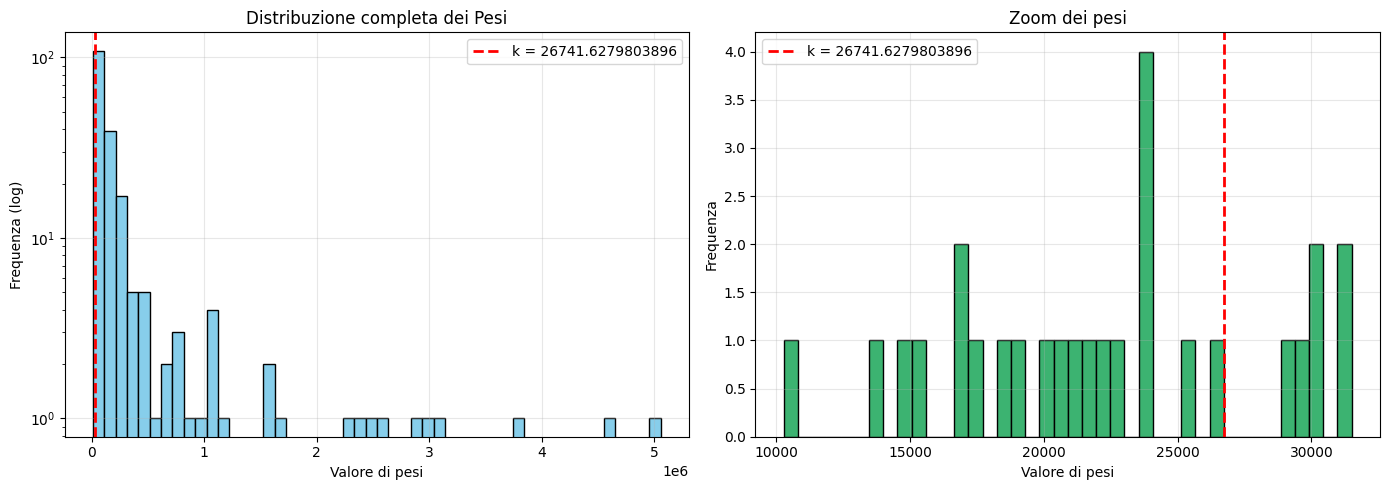

In [ ]:
from scipy.sparse import coo_matrix

def plot_count_distributions(weights_result, k_count=10*media_peso):
    counts_coo = coo_matrix(weights_result)
    counts = counts_coo.data

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].hist(counts, bins=50, color='skyblue', edgecolor='black', log=True)
    axes[0].axvline(k_count, color='red', linestyle='--', linewidth=2, label=f'k = {k_count}')
    axes[0].set_title('Distribuzione completa dei Pesi')
    axes[0].set_xlabel('Valore di pesi')
    axes[0].set_ylabel('Frequenza (log)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    counts_zoom = counts[counts <= k_count*1.2]
    axes[1].hist(counts_zoom, bins=40, color='mediumseagreen', edgecolor='black')
    axes[1].axvline(k_count, color='red', linestyle='--', linewidth=2, label=f'k = {k_count}')
    axes[1].set_title('Zoom dei pesi')
    axes[1].set_xlabel('Valore di pesi')
    axes[1].set_ylabel('Frequenza')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_count_distributions(weights_result, k_count=10*media_peso)

In [ ]:
import folium
import h3
import pandas as pd
import numpy as np
from typing import Dict, List, Optional, Tuple
import scipy.sparse as sp
from branca.colormap import linear
import json
from folium.plugins import HeatMap
import matplotlib.cm as cm
import matplotlib.colors as mcolors

class H3FoliumVisualizer:
    """
    Classe per visualizzare i risultati della generalizzazione H3 con Folium
    """
    
    def __init__(self, generalizer, center_lat=48.8566, center_lon=2.3522):
        """
        Inizializza il visualizzatore
        
        Args:
            generalizer: Istanza di OptimizedH3GeneralizedODMatrix
            center_lat, center_lon: Coordinate del centro della mappa (default: Torino)
        """
        self.generalizer = generalizer
        self.center_lat = center_lat
        self.center_lon = center_lon
        self.sparse_matrix = generalizer.current_matrix_sparse
        
        # Estrai dati dalla matrice sparse per visualizzazione
        self._extract_visualization_data()
    
    def _extract_visualization_data(self):
        print("📊 Estrazione dati per visualizzazione...")
        coo = self.sparse_matrix.tocoo()

        # Prepara liste di mapping con None per indici mancanti
        list_idx_to_start = [None] * self.sparse_matrix.shape[1]
        for idx, h3_id in self.generalizer.idx_to_start.items():
            list_idx_to_start[idx] = h3_id

        list_idx_to_end = [None] * self.sparse_matrix.shape[0]
        for idx, h3_id in self.generalizer.idx_to_end.items():
            list_idx_to_end[idx] = h3_id

        self.origin_data = {}
        self.destination_data = {}
        self.od_pairs = []

        # Calcola flussi totali per origine
        for start_idx, h3_id in enumerate(list_idx_to_start):
            if h3_id is None:
                continue
            total_flow = self.sparse_matrix[:, start_idx].sum()
            if total_flow > 0:
                self.origin_data[h3_id] = total_flow

        # Calcola flussi totali per destinazione
        for end_idx, h3_id in enumerate(list_idx_to_end):
            if h3_id is None:
                continue
            total_flow = self.sparse_matrix[end_idx, :].sum()
            if total_flow > 0:
                self.destination_data[h3_id] = total_flow

        # Estrai coppie OD
        for i, j, data in zip(coo.row, coo.col, coo.data):
            if data > 0:
                if j < len(list_idx_to_start) and i < len(list_idx_to_end):
                    origin_h3 = list_idx_to_start[j]
                    dest_h3 = list_idx_to_end[i]
                    if origin_h3 is not None and dest_h3 is not None:
                        self.od_pairs.append((origin_h3, dest_h3, data))

        print(f"✅ Estratti {len(self.origin_data)} origini, {len(self.destination_data)} destinazioni, {len(self.od_pairs)} coppie OD")

    def _h3_to_geojson(self, h3_id: str) -> Dict:
        """Converte un esagono H3 in GeoJSON"""
        boundary = h3.cell_to_boundary(h3_id)
        # H3 restituisce (lat, lon), GeoJSON vuole (lon, lat)
        coords = [[[lon, lat] for lat, lon in boundary]]
        
        return {
            "type": "Feature",
            "geometry": {
                "type": "Polygon",
                "coordinates": coords
            },
            "properties": {
                "h3_id": h3_id,
                "resolution": h3.get_resolution(h3_id)
            }
        }
    
    def create_base_map(self, zoom_start=10) -> folium.Map:
        """Crea la mappa base"""
        m = folium.Map(
            location=[self.center_lat, self.center_lon],
            zoom_start=zoom_start,
            tiles='OpenStreetMap'
        )
        
        # Aggiungi controlli layer
        folium.plugins.Fullscreen().add_to(m)
        
        return m
    
    def add_origin_hexagons(self, m: folium.Map, max_hexagons=100, alpha=0.6):
        """Aggiunge gli esagoni di origine alla mappa"""
        print(f"🔵 Aggiunta esagoni origine (max {max_hexagons})...")
        
        # Ordina per flusso e prendi i top
        sorted_origins = sorted(self.origin_data.items(), key=lambda x: x[1], reverse=True)

        # k = self.generalizer.k_threshold
        # sorted_origins = [(h3_id, flow) for h3_id, flow in sorted_origins if flow >= k]

        top_origins = sorted_origins[:max_hexagons]
        
        if not top_origins:
            print("⚠️ Nessun esagono origine da visualizzare")
            return
        
        # Calcola range per normalizzazione colori
        flows = [flow for _, flow in top_origins]
        min_flow, max_flow = min(flows), max(flows)
        
        # Gruppo layer per le origini
        origin_group = folium.FeatureGroup(name=f'Origini (Top {len(top_origins)})', show=True)
        
        for h3_id, flow in top_origins:
            try:
                # Ottieni geometria
                geojson = self._h3_to_geojson(h3_id)
                
                # Calcola intensità colore normalizzata
                if max_flow > min_flow:
                    intensity = (flow - min_flow) / (max_flow - min_flow)
                else:
                    intensity = 1.0
                
                # Usa colori esadecimali invece di rgba per evitare problemi
                # Calcola il blu con intensità variabile
                blue_intensity = int(255 * (0.3 + intensity * 0.7))
                fill_color = f"#{0:02x}{0:02x}{blue_intensity:02x}"
                
                # Aggiungi esagono con style_function semplificata
                folium.GeoJson(
                    geojson,
                    style_function=lambda x: {
                        'fillColor': fill_color,
                        'color': 'darkblue',
                        'weight': 1,
                        'fillOpacity': alpha,
                        'opacity': 0.8
                    },
                    popup=folium.Popup(
                        f"""
                        <b>Origine H3</b><br>
                        ID: {h3_id}<br>
                        Risoluzione: {h3.get_resolution(h3_id)}<br>
                        Flusso totale: {flow:,}<br>
                        Rank: {sorted_origins.index((h3_id, flow)) + 1}
                        """,
                        max_width=200
                    ),
                    tooltip=f"Origine: {flow:,} viaggi"
                ).add_to(origin_group)
                
            except Exception as e:
                print(f"⚠️ Errore nell'aggiungere esagono origine {h3_id}: {e}")
        
        origin_group.add_to(m)
        print(f"✅ Aggiunti {len(top_origins)} esagoni origine")
    
    def add_destination_hexagons(self, m: folium.Map, max_hexagons=100, alpha=0.6):
        """Aggiunge gli esagoni di destinazione alla mappa"""
        print(f"🔴 Aggiunta esagoni destinazione (max {max_hexagons})...")
        
        # Ordina per flusso e prendi i top
        sorted_destinations = sorted(self.destination_data.items(), key=lambda x: x[1], reverse=True)

        # k = self.generalizer.k_threshold
        # sorted_destinations = [(h3_id, flow) for h3_id, flow in sorted_destinations if flow >= k]

        top_destinations = sorted_destinations[:max_hexagons]
        
        if not top_destinations:
            print("⚠️ Nessun esagono destinazione da visualizzare")
            return
        
        # Gruppo layer per le destinazioni
        dest_group = folium.FeatureGroup(name=f'Destinazioni (Top {len(top_destinations)})', show=True)
        
        flows = [flow for _, flow in top_destinations]
        min_flow, max_flow = min(flows), max(flows)
        
        for h3_id, flow in top_destinations:
            try:
                geojson = self._h3_to_geojson(h3_id)
                
                # Calcola intensità colore
                if max_flow > min_flow:
                    intensity = (flow - min_flow) / (max_flow - min_flow)
                else:
                    intensity = 1.0
                
                # Usa colori esadecimali per il rosso
                red_intensity = int(255 * (0.3 + intensity * 0.7))
                fill_color = f"#{red_intensity:02x}{0:02x}{0:02x}"
                
                folium.GeoJson(
                    geojson,
                    style_function=lambda x: {
                        'fillColor': fill_color,
                        'color': 'darkred',
                        'weight': 1,
                        'fillOpacity': alpha,
                        'opacity': 0.8
                    },
                    popup=folium.Popup(
                        f"""
                        <b>Destinazione H3</b><br>
                        ID: {h3_id}<br>
                        Risoluzione: {h3.get_resolution(h3_id)}<br>
                        Flusso totale: {flow:,}<br>
                        Rank: {sorted_destinations.index((h3_id, flow)) + 1}
                        """,
                        max_width=200
                    ),
                    tooltip=f"Destinazione: {flow:,} viaggi"
                ).add_to(dest_group)
                
            except Exception as e:
                print(f"⚠️ Errore nell'aggiungere esagono destinazione {h3_id}: {e}")
        
        dest_group.add_to(m)
        print(f"✅ Aggiunti {len(top_destinations)} esagoni destinazione")

In [ ]:
visualizer = H3FoliumVisualizer(generalizer)

mappa = visualizer.create_base_map(zoom_start=11)

visualizer.add_origin_hexagons(mappa, max_hexagons=14000)
visualizer.add_destination_hexagons(mappa, max_hexagons=14000)

folium.LayerControl(collapsed=False).add_to(mappa)

mappa

📊 Estrazione dati per visualizzazione...
✅ Estratti 29 origini, 29 destinazioni, 201 coppie OD
🔵 Aggiunta esagoni origine (max 14000)...
✅ Aggiunti 29 esagoni origine
🔴 Aggiunta esagoni destinazione (max 14000)...
✅ Aggiunti 29 esagoni destinazione


In [ ]:
# CALCOLA C_DM e C_AVG
# Equivalence classes sono le coppie origine/destinazione con count >= k
# La loro grandezza è il numero di count nella matrice per qualla coppia righe/colonne
# C_DM : somma dei quadrati delle grandezze delle equivalence classes
# C_AVG : (numero totale di record / numero di equivalence classes) / k

def compute_discernability_and_cavg_sparse(sparse_matrix: sp.csr_matrix, od_matrix, suppressed_count: int, k: int) -> dict:
    
    counts = sparse_matrix.data
    total_records = counts.sum() + suppressed_count
    total_records_avg = counts.sum()
    total_equiv_classes = sparse_matrix.nnz + suppressed_count
    total_equiv_classes_avg = sparse_matrix.nnz

    # Aggiungo una penalità per i record soppressi
    # Ogni riga soppressa conta come una classe di equivalenza
    # Quindi ogni riga ha una penalità grande quanto la grandezza del dataset
    suppression_penalty = len(od_matrix) * suppressed_count

    # C_DM: somma dei quadrati dei count >= k
    k_anonymous_counts = counts[counts >= k]
    c_dm_gen = (k_anonymous_counts ** 2).sum()
    c_dm = c_dm_gen + suppression_penalty

    # CAVG: ((total_records / total_equiv_classes) / k)    
    c_avg = (total_records_avg / total_equiv_classes_avg) / k if total_equiv_classes_avg > 0 else float('inf')

    return {
        'C_DM': c_dm,
        'C_AVG': c_avg,
        'total_records': total_records,
        'total_equivalence_classes': total_equiv_classes,
        'k': k
    }

metrics = compute_discernability_and_cavg_sparse(sparse_result, od_matrix, suppressed_count=suppressed_count, k=10)
print("\n📊 Metrics di Discernibilità e CAVG:")
print(f"C_DM: {metrics['C_DM']:,}")
print(f"C_AVG: {metrics['C_AVG']:.4f}")


📊 Metrics di Discernibilità e CAVG:
C_DM: 54,289,709
C_AVG: 13.2587


In [ ]:
from geopy.distance import geodesic

def calculate_generalization_distance_metric(df_merged: pd.DataFrame, generalizer, tree_start, tree_end) -> Dict:
    
    print("🔍 Calcolo metrica di distanza post-generalizzazione...")
    
    # 1. Ottieni le mappature finali dalla generalizzazione
    final_start_mapping = generalizer.start_to_idx
    final_end_mapping = generalizer.end_to_idx
    
    # 2. Crea mapping da esagoni originali a esagoni generalizzati
    start_original_to_generalized = {}
    end_original_to_generalized = {}
    
    # Per ogni esagono originale, trova l'esagono generalizzato corrispondente
    # In 'start_original_to_generalized' e 'end_original_to_generalized' ci sono gli esagoni generalizzati
    unique_start_h3 = df_merged['start_h3'].unique()
    unique_end_h3 = df_merged['end_h3'].unique()
    
    print(f"📊 Mappatura {len(unique_start_h3)} esagoni origine...")
    for original_h3 in unique_start_h3:
        generalized_h3 = find_generalized_hexagon(original_h3, final_start_mapping, tree_start)
        if generalized_h3:
            start_original_to_generalized[original_h3] = generalized_h3
    
    print(f"📊 Mappatura {len(unique_end_h3)} esagoni destinazione...")
    for original_h3 in unique_end_h3:
        generalized_h3 = find_generalized_hexagon(original_h3, final_end_mapping, tree_end)
        if generalized_h3:
            end_original_to_generalized[original_h3] = generalized_h3
    
    # 3. Calcola distanze per i punti di partenza
    # Recupera le coordinate originali e calcola la distanza tra quel punto e l'esagono generalizzato (il centro dell'esagono)
    start_distances = []
    start_coords = []
    
    for idx, row in df_merged.iterrows():
        original_h3 = row['start_h3']
        original_coords = (row['start_lat'], row['start_lon'])
        
        if original_h3 in start_original_to_generalized:
            generalized_h3 = start_original_to_generalized[original_h3]
            # Funzione utlizzata per trovare il centro di un esagono H3
            generalized_coords = h3.cell_to_latlng(generalized_h3)
            
            # Distanza che tiene conto della curvatura della Terra (più precisa di una distanza euclidea che considera la Terra come piatta)
            distance = geodesic(original_coords, generalized_coords).meters
                
            start_distances.append(distance)
            start_coords.append({
                'original_h3': original_h3,
                'generalized_h3': generalized_h3,
                'original_coords': original_coords,
                'generalized_coords': generalized_coords,
                'distance': distance
            })
    
    # 4. Calcola distanze per i punti di destinazione
    end_distances = []
    end_coords = []
    
    for idx, row in df_merged.iterrows():
        original_h3 = row['end_h3']
        original_coords = (row['end_lat'], row['end_lon'])
        
        if original_h3 in end_original_to_generalized:
            generalized_h3 = end_original_to_generalized[original_h3]
            generalized_coords = h3.cell_to_latlng(generalized_h3)
            
            distance = geodesic(original_coords, generalized_coords).meters
                
            end_distances.append(distance)
            end_coords.append({
                'original_h3': original_h3,
                'generalized_h3': generalized_h3,
                'original_coords': original_coords,
                'generalized_coords': generalized_coords,
                'distance': distance
            })
    
    # 5. Calcola statistiche
    results = {
        'start_distances': {
            'mean': np.mean(start_distances) if start_distances else 0,
            'median': np.median(start_distances) if start_distances else 0,
            'std': np.std(start_distances) if start_distances else 0,
            'min': np.min(start_distances) if start_distances else 0,
            'max': np.max(start_distances) if start_distances else 0,
            'count': len(start_distances)
        },
        'end_distances': {
            'mean': np.mean(end_distances) if end_distances else 0,
            'median': np.median(end_distances) if end_distances else 0,
            'std': np.std(end_distances) if end_distances else 0,
            'min': np.min(end_distances) if end_distances else 0,
            'max': np.max(end_distances) if end_distances else 0,
            'count': len(end_distances)
        },
        'overall': {
            'mean': np.mean(start_distances + end_distances) if (start_distances or end_distances) else 0,
            'median': np.median(start_distances + end_distances) if (start_distances or end_distances) else 0,
            'std': np.std(start_distances + end_distances) if (start_distances or end_distances) else 0,
            'total_points': len(start_distances) + len(end_distances)
        },
        'mappings': {
            'start_original_to_generalized': start_original_to_generalized,
            'end_original_to_generalized': end_original_to_generalized
        },
        'detailed_coords': {
            'start': start_coords,
            'end': end_coords
        }
    }
    
    # 6. Stampa risultati
    print("\n" + "="*60)
    print("📏 METRICHE DI DISTANZA POST-GENERALIZZAZIONE")
    print("="*60)
    
    print(f"\n🎯 PUNTI DI PARTENZA:")
    print(f"   • Distanza media: {results['start_distances']['mean']:.2f} metri")
    print(f"   • Distanza mediana: {results['start_distances']['median']:.2f} metri")
    print(f"   • Deviazione standard: {results['start_distances']['std']:.2f} metri")
    print(f"   • Min-Max: {results['start_distances']['min']:.2f} - {results['start_distances']['max']:.2f} metri")
    print(f"   • Punti analizzati: {results['start_distances']['count']:,}")
    
    print(f"\n🏁 PUNTI DI DESTINAZIONE:")
    print(f"   • Distanza media: {results['end_distances']['mean']:.2f} metri")
    print(f"   • Distanza mediana: {results['end_distances']['median']:.2f} metri")
    print(f"   • Deviazione standard: {results['end_distances']['std']:.2f} metri")
    print(f"   • Min-Max: {results['end_distances']['min']:.2f} - {results['end_distances']['max']:.2f} metri")
    print(f"   • Punti analizzati: {results['end_distances']['count']:,}")
    
    print(f"\n🌍 COMPLESSIVO:")
    print(f"   • Distanza media totale: {results['overall']['mean']:.2f} metri")
    print(f"   • Distanza mediana totale: {results['overall']['median']:.2f} metri")
    print(f"   • Deviazione standard totale: {results['overall']['std']:.2f} metri")
    print(f"   • Punti totali: {results['overall']['total_points']:,}")
    
    return results

def find_generalized_hexagon(original_h3: str, final_mapping: Dict, tree) -> str:
    """
    Trova l'esagono generalizzato corrispondente a un esagono originale
    """
    # Se l'esagono è direttamente presente nella mappatura finale
    if original_h3 in final_mapping:
        return original_h3
    
    # Se non trovato, cerca tra TUTTI gli esagoni finali se l'originale è loro discendente
    for final_h3 in final_mapping.keys():
        if is_descendant_of(original_h3, final_h3):
            return final_h3
    
    return None

def is_descendant_of(child_h3: str, parent_h3: str) -> bool:
    """
    Controlla se child_h3 è discendente di parent_h3
    """
    child_res = h3.get_resolution(child_h3)
    parent_res = h3.get_resolution(parent_h3)
    
    if parent_res >= child_res:
        return False
    
    current = child_h3
    while h3.get_resolution(current) > parent_res:
        current = h3.cell_to_parent(current, h3.get_resolution(current) - 1)
    
    return current == parent_h3

def analyze_generalization_impact(results: Dict) -> None:
    """
    Analizza l'impatto della generalizzazione sulle distanze
    """
    print("\n" + "="*60)
    print("📊 ANALISI IMPATTO GENERALIZZAZIONE")
    print("="*60)
    
    # Calcola percentili
    all_distances = []
    for coord in results['detailed_coords']['start'] + results['detailed_coords']['end']:
        all_distances.append(coord['distance'])
    
    if all_distances:
        percentiles = [25, 50, 75, 90, 95, 99]
        print("\n📏 Distribuzione distanze:")
        for p in percentiles:
            value = np.percentile(all_distances, p)
            print(f"   • {p}° percentile: {value:.2f} metri")
    
    # Analizza per risoluzione
    resolution_analysis = {}
    for coord in results['detailed_coords']['start'] + results['detailed_coords']['end']:
        original_res = h3.get_resolution(coord['original_h3'])
        generalized_res = h3.get_resolution(coord['generalized_h3'])
        
        key = f"{original_res}→{generalized_res}"
        if key not in resolution_analysis:
            resolution_analysis[key] = []
        resolution_analysis[key].append(coord['distance'])
    
    print("\n🔍 Analisi per risoluzione:")
    for resolution_change, distances in resolution_analysis.items():
        # Distanza media per questa tipologia di generalizzazione
        mean_dist = np.mean(distances)
        # Numero di punti che hanno subito quella generalizzazione
        count = len(distances)
        print(f"   • {resolution_change}: {mean_dist:.2f}m (n={count})")


distance_results = calculate_generalization_distance_metric(
    df_merged=filtered_df, 
    generalizer=generalizer,
    tree_start=tree_start,
    tree_end=tree_end
)

analyze_generalization_impact(distance_results)

🔍 Calcolo metrica di distanza post-generalizzazione...
📊 Mappatura 6377 esagoni origine...
📊 Mappatura 6382 esagoni destinazione...

📏 METRICHE DI DISTANZA POST-GENERALIZZAZIONE

🎯 PUNTI DI PARTENZA:
   • Distanza media: 938.80 metri
   • Distanza mediana: 901.83 metri
   • Deviazione standard: 512.23 metri
   • Min-Max: 0.00 - 3698.96 metri
   • Punti analizzati: 26,650

🏁 PUNTI DI DESTINAZIONE:
   • Distanza media: 929.03 metri
   • Distanza mediana: 896.71 metri
   • Deviazione standard: 498.83 metri
   • Min-Max: 0.00 - 3684.69 metri
   • Punti analizzati: 26,650

🌍 COMPLESSIVO:
   • Distanza media totale: 933.92 metri
   • Distanza mediana totale: 900.19 metri
   • Deviazione standard totale: 505.60 metri
   • Punti totali: 53,300

📊 ANALISI IMPATTO GENERALIZZAZIONE

📏 Distribuzione distanze:
   • 25° percentile: 635.17 metri
   • 50° percentile: 900.19 metri
   • 75° percentile: 1112.04 metri
   • 90° percentile: 1276.22 metri
   • 95° percentile: 2041.09 metri
   • 99° percentil

In [ ]:
### Mean Generalisation Error : per ogni flusso anonimizzato, conta quanti esagoni originali sono inclusi nell'area generalizzata (sia per origine che destinazione)
# 
# PAPER:
# Quando le origini e le destinazioni sono aggregate più o meno allo stesso livello (come di solito accade),
# il valore medio 𝐺 rappresenta circa il doppio del numero di celle (esagoni) coinvolte 
# nell'origine o nella destinazione per ogni flusso generalizzato.
# Un valore di 𝐺 = 2 significa quindi che non è stata effettuata alcuna generalizzazione.

class GeneralizationMetric:
    """
    Ḡ = (1/V+) × Σ(|o| + |d|) × v_{o→d}
    """
        
    def __init__(self, k_threshold: int = 10):
        self.k_threshold = k_threshold
        
    def calculate_generalization_error(self, generalized_matrix: sp.csr_matrix, generalizer: 'OptimizedH3GeneralizedODMatrix') -> float:
                
        matrix_dense = generalized_matrix.toarray()
        return self._calculate_dense(matrix_dense, generalizer)
    
    def _calculate_dense(self, matrix: np.ndarray, generalizer) -> float:
        
        # Denominatore sommatoria dei flussi >= k (V+)
        total_volume_anonymous = 0  
        # Numeratore (Σ(|o| + |d|) * v_o→d)
        weighted_count_sum = 0
        
        rows, cols = matrix.shape
        
        # Scorriamo la matrice OD
        for i in range(rows):
            for j in range(cols):
                flow_value = matrix[i, j]
                
                # Considera solo i flussi >= k_threshold
                if flow_value >= self.k_threshold:
                    # Ottieni gli ID H3 dalle mappature
                    origin_h3 = generalizer.idx_to_start.get(j)
                    destination_h3 = generalizer.idx_to_end.get(i)
                    
                    if origin_h3 and destination_h3:
                        # '_get_node_count' dice quante celle originali sono state aggregate dentro ciascun nodo H3 generalizzato
                        origin_count = self._get_node_count(origin_h3, generalizer.tree_start)
                        destination_count = self._get_node_count(destination_h3, generalizer.tree_end)
                        
                        # Sommo i count per ottenere V+
                        total_volume_anonymous += flow_value
                        # Calcola il contributo del numeratore
                        weighted_count_sum += (origin_count + destination_count) * flow_value
        
        # Calcola l'errore medio
        if total_volume_anonymous > 0:
            mean_generalization_error = weighted_count_sum / total_volume_anonymous
        else:
            mean_generalization_error = 0.0
            
        return mean_generalization_error
    
    def _get_node_count(self, h3_id: str, tree) -> int:
        """
        Dato un nodo H3 generalizzato, conta quante celle originali (foglie) rappresenta.
        """
        # Caso limite : il nodo non è nell'albero
        if h3_id not in tree.nodes:
            return 0
        
        node = tree.nodes[h3_id]
        
        # Se è una foglia (livello più basso), conta 1 => l'esagono generalizzato rappresenta una cella originale
        if not node.children:
            return 1
        
        # Altrimenti, chiama _count_terminal_nodes per contare tutte le foglie sotto questo nodo
        return self._count_terminal_nodes(node, tree)
    
    def _count_terminal_nodes(self, node, tree) -> int:
        """
        Conta ricorsivamente tutti i nodi terminali sotto un nodo.
        """
        if not node.children:
            return 1
        
        total = 0
        for child_id in node.children:
            if child_id in tree.nodes:
                child_node = tree.nodes[child_id]
                total += self._count_terminal_nodes(child_node, tree)
            
        return total
    
metric = GeneralizationMetric(k_threshold=10)
error = metric.calculate_generalization_error(sparse_result, generalizer)
    
print(f"Errore di generalizzazione medio Ḡ: {error:.3f}")

Errore di generalizzazione medio Ḡ: 601.859


In [ ]:
# Parte dal nodo h3_id
# Se è un nodo foglia (nessn figlio/discnedente), lo aggiunge al set
# Se ha figli, li esplora ricorsivamente
# Il risultato sono tutti gli esagoni foglia che sono stati aggregati in h3_id

def get_leaf_descendants(h3_id: str, tree) -> set:
    """
    Ritorna tutti i nodi foglia discendenti di un nodo H3.
    """
    leaves = set()

    def _collect(node_id):
        node = tree.nodes.get(node_id)
        if not node or not node.children:
            leaves.add(node_id)
        else:
            for child_id in node.children:
                _collect(child_id)

    _collect(h3_id)
    return leaves

In [ ]:
# Per ogni nodo generalizzato
# Estrae tutti i suoi discendenti foglia
# E li associa nella forma:
# {
#     foglia_1: generalizzato_A,
#     foglia_2: generalizzato_A,
#     ...
# }

generalizer.start_generalization_map = {
    leaf_h3: gen_h3 for gen_h3 in generalizer.start_to_idx
    for leaf_h3 in get_leaf_descendants(gen_h3, tree_start)
}

generalizer.end_generalization_map = {
    leaf_h3: gen_h3 for gen_h3 in generalizer.end_to_idx
    for leaf_h3 in get_leaf_descendants(gen_h3, tree_end)
}

generalizer.start_idx_map = {h3: idx for h3, idx in generalizer.start_to_idx.items()}
generalizer.end_idx_map = {h3: idx for h3, idx in generalizer.end_to_idx.items()}

In [ ]:
# Parte dal nodo h3_id
# Se è un nodo foglia (nessn figlio/discnedente), lo aggiunge al set
# Se ha figli, li esplora ricorsivamente
# Il risultato sono tutti gli esagoni foglia che sono stati aggregati in h3_id

def get_leaf_descendants(h3_id: str, tree) -> set:
    """
    Ritorna tutti i nodi foglia discendenti di un nodo H3.
    """
    leaves = set()

    def _collect(node_id):
        node = tree.nodes.get(node_id)
        if not node or not node.children:
            leaves.add(node_id)
        else:
            for child_id in node.children:
                _collect(child_id)

    _collect(h3_id)
    return leaves

# Per ogni nodo generalizzato
# Estrae tutti i suoi discendenti foglia
# E li associa nella forma:
# {
#     foglia_1: generalizzato_A,
#     foglia_2: generalizzato_A,
#     ...
# }

generalizer.start_generalization_map = {
    leaf_h3: gen_h3 for gen_h3 in generalizer.start_to_idx
    for leaf_h3 in get_leaf_descendants(gen_h3, tree_start)
}

generalizer.end_generalization_map = {
    leaf_h3: gen_h3 for gen_h3 in generalizer.end_to_idx
    for leaf_h3 in get_leaf_descendants(gen_h3, tree_end)
}

generalizer.start_idx_map = {h3: idx for h3, idx in generalizer.start_to_idx.items()}
generalizer.end_idx_map = {h3: idx for h3, idx in generalizer.end_to_idx.items()}

# Reconstruction loss : differenza assoluta media tra i flussi originali e quelli ricostruiti, normalizzata per il volume totale

def fast_reconstruction_loss(original_od_df: pd.DataFrame,
                                  generalized_matrix: sp.csr_matrix,
                                  generalizer,
                                  tree_start,
                                  tree_end) -> float:
    """
    Calcola la reconstruction loss includendo anche le celle con 0 viaggi.
    E = (1/V) * Σ |ṽ_o→d - v_o→d|
    """

    original_dict = {
        (row['start_h3'], row['end_h3']): row['count']
        for _, row in original_od_df.iterrows()
    }

    total_volume = sum(original_dict.values())
    if total_volume == 0:
        return 0.0

    total_abs_error = 0.0

    # Precomputo foglie per ogni nodo generalizzato
    start_descendants = {gen: get_leaf_descendants(gen, tree_start) for gen in generalizer.start_to_idx}
    end_descendants   = {gen: get_leaf_descendants(gen, tree_end) for gen in generalizer.end_to_idx}

    # Lista di foglie
    start_leaves = [n for n in tree_start.nodes if not tree_start.nodes[n].children]
    end_leaves   = [n for n in tree_end.nodes if not tree_end.nodes[n].children]

    for s, d in itertools.product(start_leaves, end_leaves):
        true_count = original_dict.get((s, d), 0)

        gen_start = generalizer.start_generalization_map.get(s)
        gen_end   = generalizer.end_generalization_map.get(d)

        if gen_start is None or gen_end is None:
            reconstructed_count = 0
        else:
            row_idx = generalizer.end_idx_map.get(gen_end)
            col_idx = generalizer.start_idx_map.get(gen_start)

            if row_idx is None or col_idx is None:
                reconstructed_count = 0
            else:
                gen_count = generalized_matrix[row_idx, col_idx]
                total_combinations = len(start_descendants[gen_start]) * len(end_descendants[gen_end])
                reconstructed_count = gen_count / total_combinations if total_combinations > 0 else 0

        total_abs_error += abs(reconstructed_count - true_count)

    return total_abs_error / total_volume

In [ ]:
loss = fast_reconstruction_loss(original_od_df=od_matrix_first, generalized_matrix=sparse_result, generalizer=generalizer, tree_start=tree_start, tree_end=tree_end)
print(f"Reconstruction Loss: {loss:.6f}")

Reconstruction Loss: 1.912119


In [ ]:
# CALCOLA C_DM e C_AVG
# Equivalence classes sono le coppie origine/destinazione con count >= k
# La loro grandezza è il numero di count nella matrice per qualla coppia righe/colonne
# C_DM : somma dei quadrati delle grandezze delle equivalence classes
# C_AVG : (numero totale di record / numero di equivalence classes) / k

metrics = compute_discernability_and_cavg_sparse(weights_result, od_matrix, suppressed_count=suppressed_count, k=10*media_peso)
print("\n📊 Metrics di Discernibilità e CAVG:")
print(f"C_DM: {metrics['C_DM']:,}")
print(f"C_AVG: {metrics['C_AVG']:.4f}")


📊 Metrics di Discernibilità e CAVG:
C_DM: 134,994,027,948,191.72
C_AVG: 12.8331


In [ ]:
### Mean Generalisation Error : per ogni flusso anonimizzato, conta quanti esagoni originali sono inclusi nell'area generalizzata (sia per origine che destinazione)
# 
# PAPER:
# Quando le origini e le destinazioni sono aggregate più o meno allo stesso livello (come di solito accade),
# il valore medio 𝐺 rappresenta circa il doppio del numero di celle (esagoni) coinvolte 
# nell'origine o nella destinazione per ogni flusso generalizzato.
# Un valore di 𝐺 = 2 significa quindi che non è stata effettuata alcuna generalizzazione.
    
metric = GeneralizationMetric(k_threshold=10*media_peso)
error = metric.calculate_generalization_error(weights_result, generalizer)
    
print(f"Errore di generalizzazione medio Ḡ: {error:.3f}")

Errore di generalizzazione medio Ḡ: 592.088


In [ ]:
import itertools
import pandas as pd
import scipy.sparse as sp

def fast_reconstruction_loss(original_od_df: pd.DataFrame,
                                  generalized_matrix: sp.csr_matrix,
                                  generalizer,
                                  tree_start,
                                  tree_end) -> float:
    """
    Calcola la reconstruction loss includendo anche le celle con 0 viaggi.
    E = (1/V) * Σ |ṽ_o→d - v_o→d|
    """

    original_dict = {
        (row['start_h3'], row['end_h3']): row['total_weight']
        for _, row in original_od_df.iterrows()
    }

    total_volume = sum(original_dict.values())
    if total_volume == 0:
        return 0.0

    total_abs_error = 0.0

    # Precomputo foglie per ogni nodo generalizzato
    start_descendants = {gen: get_leaf_descendants(gen, tree_start) for gen in generalizer.start_to_idx}
    end_descendants   = {gen: get_leaf_descendants(gen, tree_end) for gen in generalizer.end_to_idx}

    # Lista di foglie
    start_leaves = [n for n in tree_start.nodes if not tree_start.nodes[n].children]
    end_leaves   = [n for n in tree_end.nodes if not tree_end.nodes[n].children]

    for s, d in itertools.product(start_leaves, end_leaves):
        true_count = original_dict.get((s, d), 0)

        gen_start = generalizer.start_generalization_map.get(s)
        gen_end   = generalizer.end_generalization_map.get(d)

        if gen_start is None or gen_end is None:
            reconstructed_count = 0
        else:
            row_idx = generalizer.end_idx_map.get(gen_end)
            col_idx = generalizer.start_idx_map.get(gen_start)

            if row_idx is None or col_idx is None:
                reconstructed_count = 0
            else:
                gen_count = generalized_matrix[row_idx, col_idx]
                total_combinations = len(start_descendants[gen_start]) * len(end_descendants[gen_end])
                reconstructed_count = gen_count / total_combinations if total_combinations > 0 else 0

        total_abs_error += abs(reconstructed_count - true_count)

    return total_abs_error / total_volume

loss = fast_reconstruction_loss(original_od_df=od_matrix_first, generalized_matrix=weights_result, generalizer=generalizer, tree_start=tree_start, tree_end=tree_end)
print(f"Reconstruction Loss: {loss:.6f}")

Reconstruction Loss: 1.919127
